# 融合模型表示可视化（Fusion 层 → t-SNE）

对 **Fusion_PSSM1110** 融合模型提取「融合层」表示（`fusion_dense` 输出，128 维），在 **训练集 / 验证集 / 测试集** 上分别做 t-SNE（共 3 张图）。
若未找到已保存权重，则用固定 seed 训练一次并保存权重；表示结果缓存于 `pssm_work/features/`。

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
os.environ["CUDA_VISIBLE_DEVICES"] = ""
from tensorflow import keras

PROJECT_ROOT = '/home/nemophila/projects/protein_bert'
BENCHMARKS_DIR = os.path.join(PROJECT_ROOT, 'anticrispr_benchmarks')
WORK_ROOT = os.path.join(PROJECT_ROOT, 'pssm_work')
FEAT_DIR = os.path.join(WORK_ROOT, 'features')
FUSION_SEED = 42
PSSM_DIM = '1110'
os.makedirs(FEAT_DIR, exist_ok=True)

FUSION_WEIGHTS_PATH = os.path.join(FEAT_DIR, f'fusion_weights_pssm{PSSM_DIM}_seed{FUSION_SEED}.keras')

def fusion_cache_path(split):
    return (
        os.path.join(FEAT_DIR, f'fusion_embeddings_{split}.npy'),
        os.path.join(FEAT_DIR, f'fusion_labels_{split}.npy'),
    )

2026-02-20 20:01:29.911841: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [2]:
from proteinbert import (
    load_anticrispr_with_ids,
    load_feature_cache,
    attach_pssm_features,
    load_pretrained_model,
    FusionTrainConfig,
)
from proteinbert.pssm_fusion import _build_late_fusion_model, _encode_x

parquet_path = os.path.join(FEAT_DIR, f'pssm_features_{PSSM_DIM}.parquet')
csv_path = os.path.join(FEAT_DIR, f'pssm_features_{PSSM_DIM}.csv')
cache_path = parquet_path if os.path.exists(parquet_path) else csv_path
feat_df, feat_cols = load_feature_cache(cache_path)
train_df, test_df = load_anticrispr_with_ids(BENCHMARKS_DIR, benchmark_name='anticrispr_binary')
train_df = attach_pssm_features(train_df, feat_df, feat_cols)
test_df = attach_pssm_features(test_df, feat_df, feat_cols)

sub_train, sub_valid = train_test_split(
    train_df, test_size=0.1, stratify=train_df['label'], random_state=FUSION_SEED
)

x_train = sub_train[feat_cols].to_numpy(dtype=np.float32)
x_valid = sub_valid[feat_cols].to_numpy(dtype=np.float32)
x_test = test_df[feat_cols].to_numpy(dtype=np.float32)
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_valid = scaler.transform(x_valid)
x_test = scaler.transform(x_test)

splits_data = {
    'train': (sub_train['seq'].tolist(), x_train, sub_train['label'].astype(int).to_numpy()),
    'valid': (sub_valid['seq'].tolist(), x_valid, sub_valid['label'].astype(int).to_numpy()),
    'test':  (test_df['seq'].tolist(),  x_test,  test_df['label'].astype(int).to_numpy()),
}
cfg = FusionTrainConfig()
for name, (seqs, _, labels) in splits_data.items():
    print(f'{name}: n={len(seqs)}, Acr={labels.sum()}')

train: n=996, Acr=184
valid: n=111, Acr=21
test: n=286, Acr=26


## 加载或训练融合模型并保存权重

In [3]:
pmg, enc = load_pretrained_model(
    local_model_dump_dir=os.path.join(PROJECT_ROOT, 'proteinbert_models'),
    download_model_dump_if_not_exists=True,
    validate_downloading=False,
)

if os.path.exists(FUSION_WEIGHTS_PATH):
    model = _build_late_fusion_model(pmg, cfg.seq_len, len(feat_cols), False, cfg)
    model.load_weights(FUSION_WEIGHTS_PATH)
    print('Loaded fusion weights from', FUSION_WEIGHTS_PATH)
else:
    print('Training fusion model (one run), then saving weights...')
    y_tr = splits_data['train'][2]
    y_va = splits_data['valid'][2]
    X_tr = _encode_x(enc, splits_data['train'][0], cfg.seq_len, splits_data['train'][1])
    X_va = _encode_x(enc, splits_data['valid'][0], cfg.seq_len, splits_data['valid'][1])
    model = _build_late_fusion_model(pmg, cfg.seq_len, len(feat_cols), freeze_pretrained_layers=True, cfg=cfg)
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=cfg.frozen_lr), loss='binary_crossentropy')
    model.fit(X_tr, y_tr, validation_data=(X_va, y_va), epochs=cfg.frozen_epochs, batch_size=cfg.batch_size,
              callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=cfg.patience, restore_best_weights=True)], verbose=0)
    for layer in model.layers:
        layer.trainable = True
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=cfg.unfrozen_lr), loss='binary_crossentropy')
    model.fit(X_tr, y_tr, validation_data=(X_va, y_va), epochs=cfg.unfrozen_epochs, batch_size=cfg.batch_size,
              callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=cfg.patience, restore_best_weights=True)], verbose=0)
    model.save_weights(FUSION_WEIGHTS_PATH)
    print('Saved', FUSION_WEIGHTS_PATH)

Training fusion model (one run), then saving weights...


2026-02-20 20:01:31.585738: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2026-02-20 20:01:31.586728: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2026-02-20 20:01:31.593121: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2026-02-20 20:01:31.593142: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: liyue-SYS-221H-TNR
2026-02-20 20:01:31.593147: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: liyue-SYS-221H-TNR
2026-02-20 20:01:31.593283: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 535.104.5
2026-02-20 20:01:31.593302: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 535.104.5
2026-02-20 20:01:31.593306: I tensorflo

Saved /home/nemophila/projects/protein_bert/pssm_work/features/fusion_weights_pssm1110_seed42.keras


## 提取 fusion_dense 表示并缓存（train / valid / test）

In [4]:
embedding_model = keras.Model(inputs=model.inputs, outputs=model.get_layer('fusion_dense').output)

embeddings_by_split = {}
labels_by_split = {}
all_cached = all(
    os.path.exists(fusion_cache_path(s)[0]) and os.path.exists(fusion_cache_path(s)[1])
    for s in ('train', 'valid', 'test')
)

if all_cached:
    for s in ('train', 'valid', 'test'):
        ep, lp = fusion_cache_path(s)
        embeddings_by_split[s] = np.load(ep)
        labels_by_split[s] = np.load(lp)
        print(f'Loaded {s}:', embeddings_by_split[s].shape)
else:
    for s in ('train', 'valid', 'test'):
        seqs, pssm, labels = splits_data[s][0], splits_data[s][1], splits_data[s][2]
        X = _encode_x(enc, seqs, cfg.seq_len, pssm)
        emb = embedding_model.predict(X, batch_size=cfg.batch_size, verbose=0)
        embeddings_by_split[s] = emb
        labels_by_split[s] = labels
        ep, lp = fusion_cache_path(s)
        np.save(ep, emb)
        np.save(lp, labels)
        print(f'Saved {s}:', emb.shape)

Saved train: (996, 128)
Saved valid: (111, 128)
Saved test: (286, 128)


## t-SNE：训练集 / 验证集 / 测试集（各一张图）

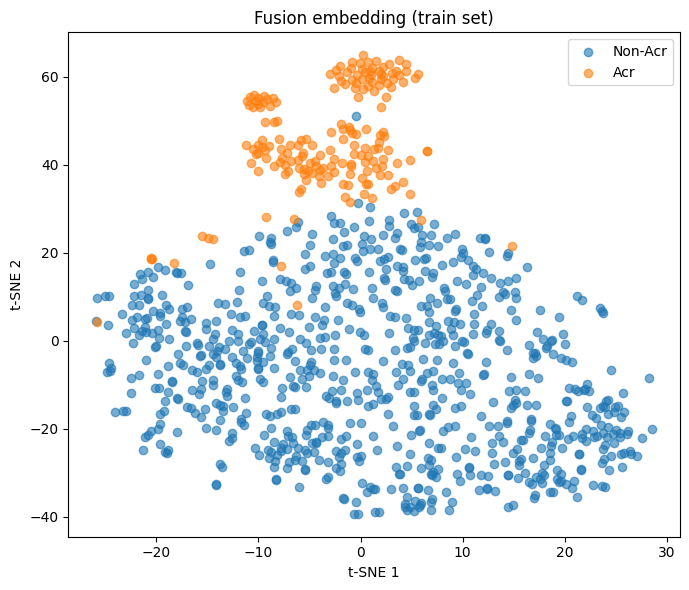

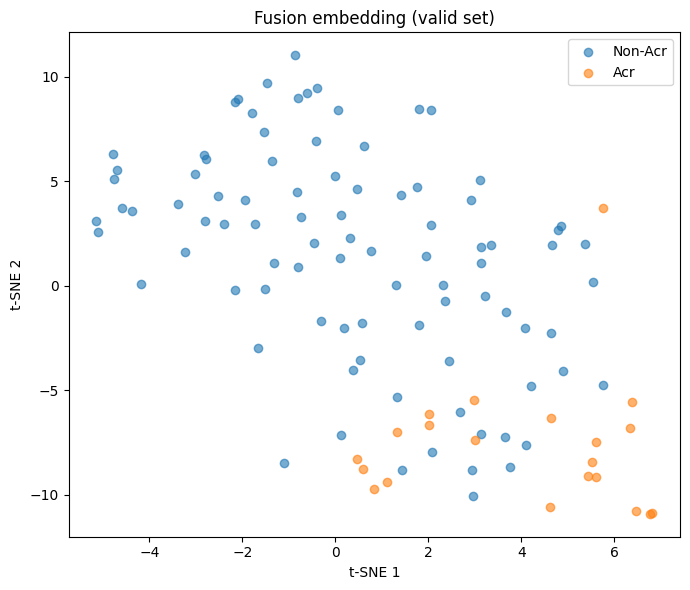

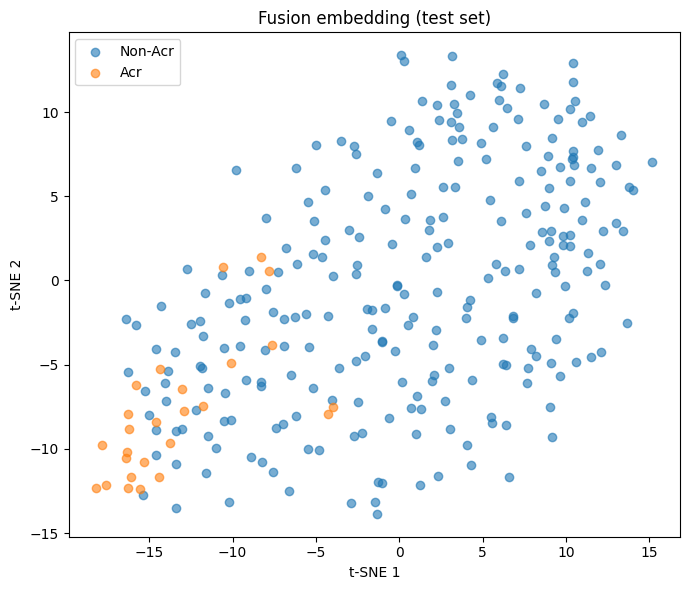

In [5]:
from sklearn.manifold import TSNE

for split_name in ('train', 'valid', 'test'):
    if split_name not in embeddings_by_split:
        ep, lp = fusion_cache_path(split_name)
        embeddings_by_split[split_name] = np.load(ep)
        labels_by_split[split_name] = np.load(lp)
    emb = embeddings_by_split[split_name]
    lab = labels_by_split[split_name]
    tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, max(5, len(emb)//4)))
    emb_2d = tsne.fit_transform(emb)
    fig, ax = plt.subplots(figsize=(7, 6))
    for l, name in [(0, 'Non-Acr'), (1, 'Acr')]:
        mask = lab == l
        ax.scatter(emb_2d[mask, 0], emb_2d[mask, 1], alpha=0.6, label=name)
    ax.set_xlabel('t-SNE 1')
    ax.set_ylabel('t-SNE 2')
    ax.legend()
    ax.set_title(f'Fusion embedding ({split_name} set)')
    plt.tight_layout()
    plt.show()